In [6]:
from enrichment_functions import * 

import matplotlib.pyplot as plt
from draw_wordcloud import draw_word_cloud

from Bio import SeqIO

import json
import gzip

### Parse GO files

In [26]:
# file containing gene ontology
GO_FILE_PATH = "../../data/go.json.gz"

# file containin HUMAN GO annotations
MAP_FILE_PATH = "../../data/goa_human.gaf.gz"

In [27]:
# read ontology file
with gzip.open(GO_FILE_PATH) as f:
    ontology = json.load(f)

# parse ontology
labels, ancestors, min_depth = parse_gene_ontology(ontology)

In [28]:
# Map proteins ID to GO term
protein_to_go = map_protein_to_go(MAP_FILE_PATH)

# Original Dataset

In [125]:
# read the original dataset (hits retrieved by our model)
with open("../../datasets/original.txt") as f:
    dataset = f.read().splitlines()

In [126]:
len(dataset)

92

In [75]:
# background datasets is the entire human proteom in SwissProt
human = SeqIO.parse('../../data/SwissProt_humans_reference_all.fasta','fasta')
background = []
for sequence in human:
    name = sequence.id # name is in the form sp|P46108|CRK_HUMAN
    background.append(name.split('|')[1])

In [76]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_go)
background_count = count_ancestors(background, ancestors, protein_to_go)

In [77]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [78]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [80]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0033277,102.965166,0.000548,4,abortive mitotic cell cycle
0035685,102.965166,0.000548,4,helper T cell diapedesis
0046544,102.958708,0.019147,4,development of secondary male sexual character...
0001545,102.958708,0.019147,2,primary ovarian follicle growth
0008269,102.958708,0.019147,5,JAK pathway signal transduction adaptor activity


In [11]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.05
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 1.9297568506368197e-05


In [12]:
# filter by depth
filter_terms = (result_fisher["depth"] <= 3) & (result_fisher["p-value"] <= adjusted_threshold)

result_fisher[filter_terms].head()

,OddRatio,p-value,depth,label
0005942,44.155188,2.723075e-15,3,phosphatidylinositol 3-kinase complex
0051219,38.067051,1.430328e-35,3,phosphoprotein binding
0031295,23.326910,1.571818e-12,3,T cell costimulation
0031294,22.894917,1.904113e-12,2,lymphocyte costimulation
0005158,22.387696,6.727561e-06,3,insulin receptor binding


Visualize the first term here

https://www.ebi.ac.uk/QuickGO/GTerm?id=GO:0005942

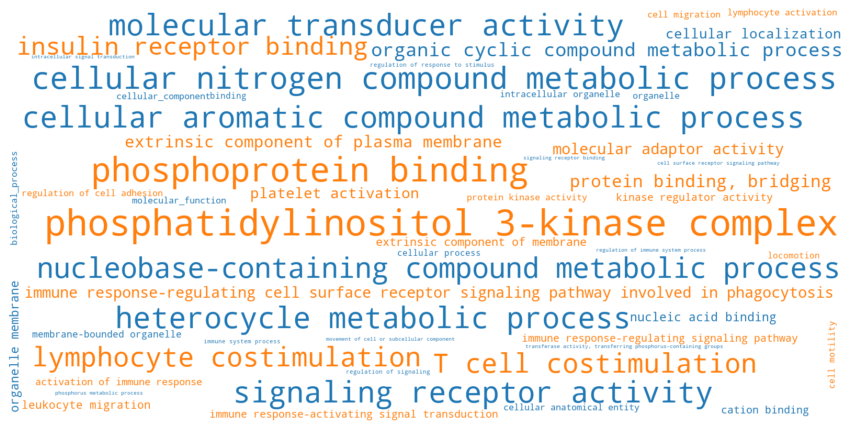

In [14]:
# Num of words to be drawn
N = 30

wc = draw_word_cloud(
    df = result_fisher[filter_terms],
    N = N,
    score = 'OddRatio',
    scale = 2,
    under_represented=True
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Architectures Datasets

In [16]:
# file containing architectures datasets
ARCH_FILE_PATH = "../../datasets/architectures_datasets.json"

In [17]:
# read architecture
with open(ARCH_FILE_PATH) as f:
    arch_dataset = json.load(f)

In [31]:
# read the original dataset (hits retrieved by our model)
# it will be the background dataset
with open("../../datasets/original.txt") as f:
    bg_dataset = f.read().splitlines()

In [32]:
# count the anchestors for each sequence of the dataset
background_count = count_ancestors(bg_dataset, ancestors, protein_to_go)

In [89]:
# create a list of df, in each one of them there is the results

# NB non credo che abbia troppo senso usare dataset composti da poche proteine
# filtro solo i dataset con più di 3
results = {}
filtered_results = {}

for key in arch_dataset:
    
    dataset = arch_dataset[key]
    
    if len(dataset) > 3:
        print(len(dataset))
    
        dataset_count = count_ancestors(dataset, ancestors, protein_to_go)

        # perform fisher exact test
        result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)
        result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

        # add depth and description columns
        result = add_depth_description(
            df = result_fisher,
            min_depth = min_depth, 
            labels = labels )

        results[key] = result
        
        # Bonferroni correction
        # adjust threshold based on the numbe of tests
        # http://www.biostathandbook.com/multiplecomparisons.html
        alpha = 0.05
        m = result_fisher.shape[0]
        adjusted_threshold = alpha/m
            
        # filter by depth
        filter_terms = (result_fisher["depth"] <= 3) & (result_fisher["p-value"] <= adjusted_threshold)
        filtered_results[key] = result_fisher[filter_terms]
        
    
    

6
15
13
4
6


In [91]:
filtered_results.keys()

dict_keys(['PF00017,PF00018', 'PF00017', 'PF00017,PF00018,PF07714', 'PF00640,PF00017', 'PF07525,PF00017'])

In [92]:
filtered_results['PF00017,PF00018']

,OddRatio,p-value,depth,label
0030674,61.139822,3.115884e-08,3,"protein binding, bridging"
0060090,48.336258,9.767954e-08,2,molecular adaptor activity


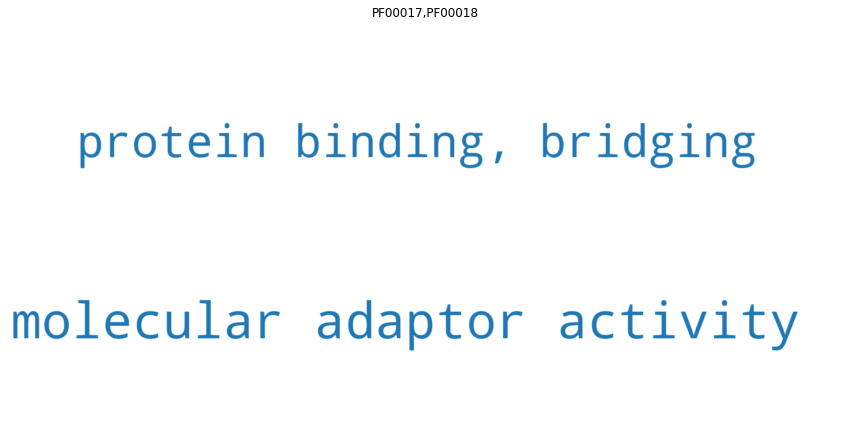

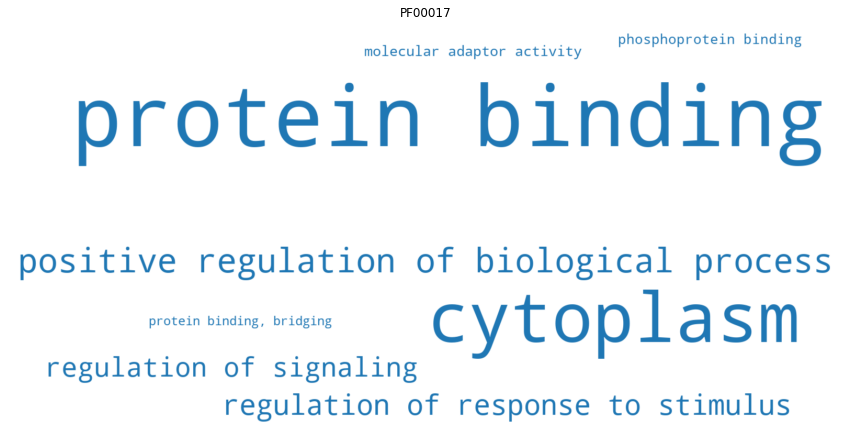

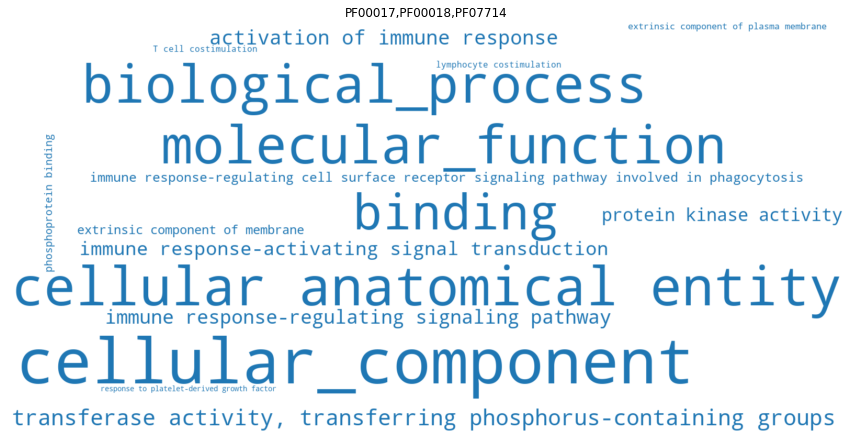

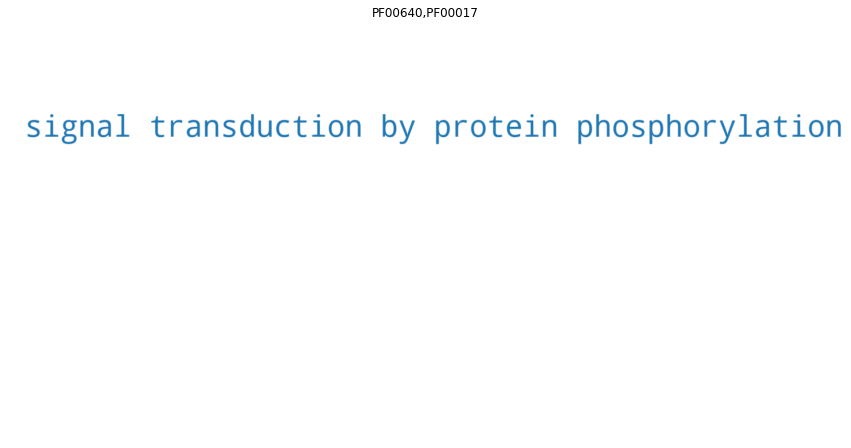

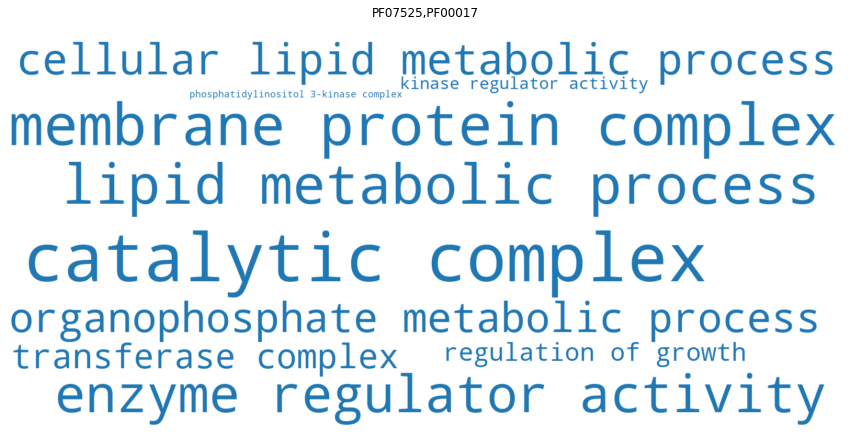

In [93]:
# draw wordcloud
for key in filtered_results:
    
    # Num of words to be drawn
    N = 30

    wc = draw_word_cloud(
        df = filtered_results[key],
        N = N,
        score = 'OddRatio',
        scale = 2,
        under_represented=True
    )

    # Plot
    plt.figure(figsize=(15, 15))
    plt.title(key)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# PDB Network dataset

In [127]:
# output dataset: save pdb dataset
PDB_PATH = '../../datasets/pdb.cvs'
PDB_BG_PATH = '../../datasets/pdb_bg.txt'

In [128]:
# read the BG dataset (hits retrieved by our model)
with open(PDB_BG_PATH) as f:
    bg_dataset = f.read().splitlines()

In [129]:
len(bg_dataset)

6748

In [130]:
dataset_df = pd.read_csv(PDB_PATH)

In [131]:
dataset = dataset_df.sp_primary.unique()

In [132]:
len(dataset)

110

In [133]:
# count the anchestors for each sequence of the dataset
dataset_count = count_ancestors(dataset, ancestors, protein_to_go)
background_count = count_ancestors(bg_dataset, ancestors, protein_to_go)

In [134]:
# perform fisher exact test
result_fisher = fisher_test(dataset_count, background_count, min_depth, labels)

In [135]:
result_fisher.sort_values(by = "OddRatio", ascending=False, inplace=True)

In [136]:
# add depth and description columns
result = add_depth_description(
    df = result_fisher,
    min_depth = min_depth, 
    labels = labels
)
result.head()

,OddRatio,p-value,depth,label
0071226,35.279088,0.004393,4,cellular response to molecule of fungal origin
0032044,35.279088,0.004393,3,DSIF complex
0048408,35.279088,0.004393,3,epidermal growth factor binding
0005943,35.279088,0.004393,5,"phosphatidylinositol 3-kinase complex, class IA"
2001160,35.279088,0.004393,9,regulation of histone H3-K79 methylation


In [137]:
# Bonferroni correction
# adjust threshold based on the numbe of tests
# http://www.biostathandbook.com/multiplecomparisons.html
alpha = 0.05
m = result_fisher.shape[0]
adjusted_threshold = alpha/m
print("Adjusted threshold: {}".format(adjusted_threshold))

Adjusted threshold: 1.3408420488066507e-05


In [138]:
# filter by depth
filter_terms = (result_fisher["depth"] <= 3) & (result_fisher["p-value"] <= adjusted_threshold)

result_fisher[filter_terms].head()

,OddRatio,p-value,depth,label
0005942,17.643563,1.648869e-07,3,phosphatidylinositol 3-kinase complex
0051219,14.124392,1.974675e-19,3,phosphoprotein binding
0031295,12.550197,6.898018e-12,3,T cell costimulation
0031294,12.277353,9.057317e-12,2,lymphocyte costimulation
0002433,9.169317,2.252210e-12,3,immune response-regulating cell surface recept...


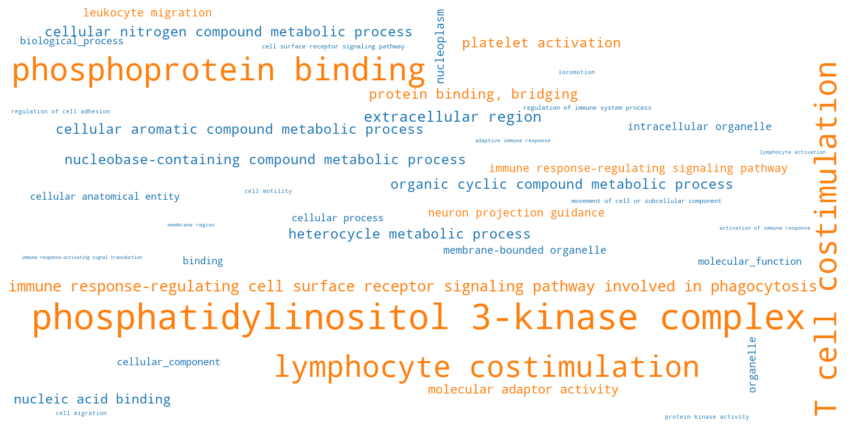

In [139]:
# Num of words to be drawn
N = 30

wc = draw_word_cloud(
    df = result_fisher[filter_terms],
    N = N,
    score = 'OddRatio',
    scale = 2,
    under_represented=True
)

# Plot
plt.figure(figsize=(15, 15))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()